# Тестовое задание

Исполнитель: Владислав Кудюров

Задача 2:



1.   Проведите аналитику полученных данных

2.   Подготовьте данные для модели классификации
3.   Обучите модель классификации и осуществите прогноз для отложенной выборки с учетомо перекоса в данных TARGET
4.   Оцените качество модели с помощью функции f1_score





In [258]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
import warnings
rcParams['figure.figsize'] = 20, 10
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import utils
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [259]:
# подключаем гугл драйв диск для загрузки файлов
from google.colab import drive 
drive.mount('/content/drive')

# Указываем путь к данным
PATH = '/content/drive/My Drive/datasets/test_magnit/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [260]:
# Загружаем данные 
df = pd.read_csv(PATH + 'data_classification_for_task.csv')
df.index += 1
display(df)

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
1,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
2,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
3,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
4,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
5,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
300,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
301,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
302,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [261]:
# Выведем информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 1 to 303
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AGE         303 non-null    int64  
 1   GENDER      303 non-null    int64  
 2   FEATURE_1   303 non-null    int64  
 3   FEATURE_2   303 non-null    int64  
 4   FEATURE_3   303 non-null    int64  
 5   FEATURE_4   303 non-null    int64  
 6   FEATURE_5   303 non-null    int64  
 7   FEATURE_6   303 non-null    int64  
 8   FEATURE_7   303 non-null    int64  
 9   FEATURE_8   303 non-null    float64
 10  FEATURE_9   303 non-null    int64  
 11  FEATURE_10  303 non-null    int64  
 12  FEATURE_11  303 non-null    int64  
 13  TARGET      303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [262]:
# Функция для вычисления процентного списка пропущенных данных
def get_persent(fn):
  try:
    for col in fn.columns:
      pct_missing = np.mean(fn[col].isnull())
      print('{} - {}%'.format(col, round(pct_missing*100, 3)))
  except ValueError:
    print('Error DataFrame')

In [263]:
# Oтображения сводной статистики числовых переменных
print(f'Сводная статистика числовых переменных:\n {df.describe().T}')

# Проверка датасета на отсутствие данных 
print(f'\nСумма пропущенных значений в переменных:\n{df.isna().sum()}')
print(f'\nПроцент пропущенных данных:')
get_persent(df)

Сводная статистика числовых переменных:
             count        mean        std    min    25%    50%    75%    max
AGE         303.0   54.366337   9.082101   29.0   47.5   55.0   61.0   77.0
GENDER      303.0    0.683168   0.466011    0.0    0.0    1.0    1.0    1.0
FEATURE_1   303.0    0.966997   1.032052    0.0    0.0    1.0    2.0    3.0
FEATURE_2   303.0  131.623762  17.538143   94.0  120.0  130.0  140.0  200.0
FEATURE_3   303.0  246.264026  51.830751  126.0  211.0  240.0  274.5  564.0
FEATURE_4   303.0    0.148515   0.356198    0.0    0.0    0.0    0.0    1.0
FEATURE_5   303.0    0.528053   0.525860    0.0    0.0    1.0    1.0    2.0
FEATURE_6   303.0  149.646865  22.905161   71.0  133.5  153.0  166.0  202.0
FEATURE_7   303.0    0.326733   0.469794    0.0    0.0    0.0    1.0    1.0
FEATURE_8   303.0    1.039604   1.161075    0.0    0.0    0.8    1.6    6.2
FEATURE_9   303.0    1.399340   0.616226    0.0    1.0    1.0    2.0    2.0
FEATURE_10  303.0    0.729373   1.022606    0.0

Text(0.5, 0, '')

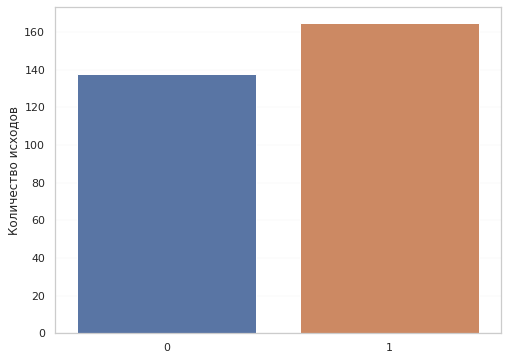

In [264]:
# Посмотрим переменную, которую будем предсказывать
pos = df[df['TARGET'] == 0].shape[0]
neg = df[df['TARGET'] == 1].shape[0]
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
plt.figure(figsize=(8, 6))
sns.countplot(df['TARGET'])
plt.xticks((0, 1), ['0', "1"])
plt.ylabel('Количество исходов')
plt.xlabel("")


In [265]:
print(f'Количество исходов с событием 0: {pos}')
print(f'Количество исходов с событием 1: {neg}')
print(f'Соотношение между исходами: {(pos / neg) * 100:.2f}%')

Количество исходов с событием 0: 138
Количество исходов с событием 1: 165
Соотношение между исходами: 83.64%


# Подготовьте данные для модели классификации


In [266]:
# Переведем переменную в режим int
df['FEATURE_8'] = df['FEATURE_8'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 1 to 303
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   AGE         303 non-null    int64
 1   GENDER      303 non-null    int64
 2   FEATURE_1   303 non-null    int64
 3   FEATURE_2   303 non-null    int64
 4   FEATURE_3   303 non-null    int64
 5   FEATURE_4   303 non-null    int64
 6   FEATURE_5   303 non-null    int64
 7   FEATURE_6   303 non-null    int64
 8   FEATURE_7   303 non-null    int64
 9   FEATURE_8   303 non-null    int64
 10  FEATURE_9   303 non-null    int64
 11  FEATURE_10  303 non-null    int64
 12  FEATURE_11  303 non-null    int64
 13  TARGET      303 non-null    int64
dtypes: int64(14)
memory usage: 33.3 KB


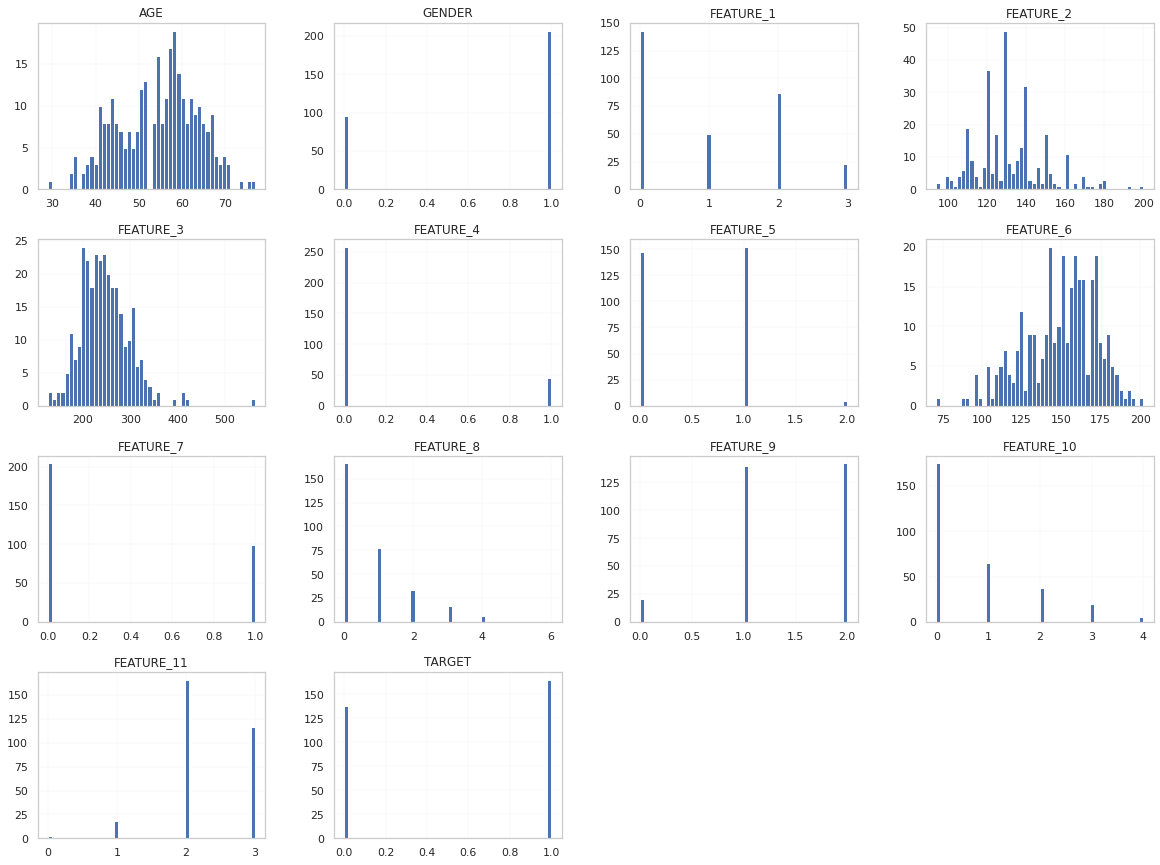

In [267]:
# Строим гистограмму для каждой числовой переменной, чтоб узнать тип данных
df.hist(bins=50, figsize=(20,15))
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
plt.savefig("attribute_histogram_plots")
plt.show()

In [268]:
# Проверим корреляцию между переменными
data_matrix = df.corr()
data_matrix["TARGET"].sort_values(ascending=False)

TARGET        1.000000
FEATURE_1     0.433798
FEATURE_6     0.421741
FEATURE_9     0.345877
FEATURE_5     0.137230
FEATURE_4    -0.028046
FEATURE_3    -0.085239
FEATURE_2    -0.144931
AGE          -0.225439
GENDER       -0.280937
FEATURE_11   -0.344029
FEATURE_10   -0.391724
FEATURE_8    -0.423572
FEATURE_7    -0.436757
Name: TARGET, dtype: float64

In [269]:
# Оценим баланс классов, которые нам необходимо предсказывать в нашей изначальной выборке
df.TARGET.value_counts(normalize=True)

1    0.544554
0    0.455446
Name: TARGET, dtype: float64

In [270]:
# Обозначаем X и Y
X = df.drop('TARGET', axis=1)
indx = X.index
y = df['TARGET']


In [271]:
#  Разобъем всю выборку на три части: обучающую, валидационную и тестовую.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=.3)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, random_state=42, test_size=.5)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')
print(f'X_valid: {X_valid.shape}, y_valid: {y_valid.shape}')

X_train: (212, 13), y_train: (212,)
X_test: (46, 13), y_test: (46,)
X_valid: (45, 13), y_valid: (45,)


In [272]:
# Обучим простейшую модель классификации K-ближайших соседей, 
# на не сбалансированном датасете и сравним предсказание данной модели со случайной моделью

for n_neighbors in range(1, 10):
    knc = KNeighborsClassifier(n_neighbors=n_neighbors)
    predicted = knc.fit(X_train, y_train).predict(X_valid)
    probabilities_valid = knc.predict_proba(X_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    print(f'n: {n_neighbors}\tAccuracy: {round(knc.score(X_train, y_train), 3)}\
    \tF1: {round(f1_score(y_valid.values, predicted),3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

n: 1	Accuracy: 1.0    	F1: 0.604    	ROC AUC: 0.524
n: 2	Accuracy: 0.783    	F1: 0.651    	ROC AUC: 0.669
n: 3	Accuracy: 0.778    	F1: 0.679    	ROC AUC: 0.695
n: 4	Accuracy: 0.755    	F1: 0.667    	ROC AUC: 0.729
n: 5	Accuracy: 0.769    	F1: 0.727    	ROC AUC: 0.716
n: 6	Accuracy: 0.759    	F1: 0.64    	ROC AUC: 0.653
n: 7	Accuracy: 0.745    	F1: 0.667    	ROC AUC: 0.678
n: 8	Accuracy: 0.722    	F1: 0.667    	ROC AUC: 0.686
n: 9	Accuracy: 0.722    	F1: 0.679    	ROC AUC: 0.681


Будем ориентироваться на F1-меру, максимальное значение данная метрика имеет при количестве соседей равным 5.



In [273]:
# Проверим нашу модель на адекватность, сгенерируем псевдослучайную последовательность 0 и 1, 
# равную размером с тестовой выборкой и сравним метрики

y_random = [np.random.randint(0, 2) for i in range(len(y_test))]

# Обучим нашу модель с гиперпареметром количчества соседей - 5
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
probabilities_valid = model.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]

print("F1 на тестовой выборке: {:.3f}".format(f1_score(y_test, predicted)))
print("F1 на случайной выборке: {:.3f}".format(f1_score(y_random, predicted)))

print("ROC AUC на тестовой выборке: {:.3f}".format(roc_auc_score(y_test, probabilities_one_valid)))
print("ROC AUC на случайной выборке: {:.3f}".format(roc_auc_score(y_random, probabilities_one_valid)))

F1 на тестовой выборке: 0.667
F1 на случайной выборке: 0.571
ROC AUC на тестовой выборке: 0.727
ROC AUC на случайной выборке: 0.551


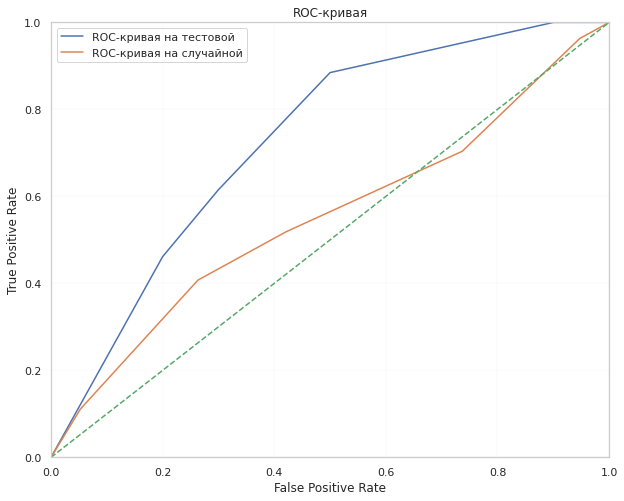

In [274]:
fpr_test, tpr_test, thresholds = roc_curve(y_test, probabilities_one_valid)
fpr_random, tpr_random, thresholds = roc_curve(y_random, probabilities_one_valid)
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, label='ROC-кривая на тестовой')
plt.plot(fpr_random, tpr_random, label='ROC-кривая на случайной')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

# Обучите модель классификации и осуществите прогноз для отложенной выборки с учетомо перекоса в данных TARGET.  

In [275]:
# Оценим баланс классов, которые нам необходимо предсказывать в нашей изначальной выборке
df.TARGET.value_counts(normalize=True)

1    0.544554
0    0.455446
Name: TARGET, dtype: float64

In [276]:
# K-ближайших соседей
%%time
for n_neighbors in range(1, 9):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    predicted = model.fit(X_train, y_train).predict(X_valid)
    probabilities_one_valid = model.predict_proba(X_valid)[:, 1]   
    print(f'K: {n_neighbors}\tF1-мера на валидации: {round(f1_score(y_valid, predicted), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

K: 1	F1-мера на валидации: 0.604    	ROC AUC: 0.524
K: 2	F1-мера на валидации: 0.651    	ROC AUC: 0.669
K: 3	F1-мера на валидации: 0.679    	ROC AUC: 0.695
K: 4	F1-мера на валидации: 0.667    	ROC AUC: 0.729
K: 5	F1-мера на валидации: 0.727    	ROC AUC: 0.716
K: 6	F1-мера на валидации: 0.64    	ROC AUC: 0.653
K: 7	F1-мера на валидации: 0.667    	ROC AUC: 0.678
K: 8	F1-мера на валидации: 0.667    	ROC AUC: 0.686
CPU times: user 62.9 ms, sys: 4.06 ms, total: 67 ms
Wall time: 65.2 ms


In [277]:
# Логистическая регрессия
%%time
model = LogisticRegression(solver='liblinear')
predicted = model.fit(X_train, y_train).predict(X_valid)
probabilities_one_valid = model.predict_proba(X_valid)[:, 1]  
print(f'F1-мера на валидации: {round(f1_score(y_valid, predicted), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

F1-мера на валидации: 0.857    	ROC AUC: 0.942
CPU times: user 9.66 ms, sys: 0 ns, total: 9.66 ms
Wall time: 10.1 ms


In [278]:
# Классификатор линейных векторов
%%time
model = LinearSVC(random_state=42)
predicted = model.fit(X_train, y_train).predict(X_valid)
probabilities_one_valid = model.decision_function(X_valid) > 0 
print(f'F1-мера на валидации: {round(f1_score(y_valid, predicted), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

F1-мера на валидации: 0.889    	ROC AUC: 0.857
CPU times: user 20.4 ms, sys: 12 µs, total: 20.4 ms
Wall time: 20.7 ms


In [279]:
# Метод опорных векторов
%%time
model = SVC(C=10, gamma=3, random_state=42, probability=True)
predicted = model.fit(X_train, y_train).predict(X_valid)
probabilities_one_valid = model.predict_proba(X_valid)[:, 1]  
print(f'F1-мера на валидации: {round(f1_score(y_valid, predicted), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

F1-мера на валидации: 0.696    	ROC AUC: 0.479
CPU times: user 26.5 ms, sys: 0 ns, total: 26.5 ms
Wall time: 26.9 ms


In [280]:
# Дерево решений
%%time
for max_depth in range(10, 30, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    predicted = model.fit(X_train, y_train).predict(X_valid)
    probabilities_one_valid = model.predict_proba(X_valid)[:, 1]   
    print(f'Глубина: {max_depth}\tF1-мера на валидации: {round(f1_score(y_valid, predicted), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

Глубина: 10	F1-мера на валидации: 0.816    	ROC AUC: 0.798
Глубина: 12	F1-мера на валидации: 0.816    	ROC AUC: 0.798
Глубина: 14	F1-мера на валидации: 0.816    	ROC AUC: 0.798
Глубина: 16	F1-мера на валидации: 0.816    	ROC AUC: 0.798
Глубина: 18	F1-мера на валидации: 0.816    	ROC AUC: 0.798
Глубина: 20	F1-мера на валидации: 0.816    	ROC AUC: 0.798
Глубина: 22	F1-мера на валидации: 0.816    	ROC AUC: 0.798
Глубина: 24	F1-мера на валидации: 0.816    	ROC AUC: 0.798
Глубина: 26	F1-мера на валидации: 0.816    	ROC AUC: 0.798
Глубина: 28	F1-мера на валидации: 0.816    	ROC AUC: 0.798
CPU times: user 50.1 ms, sys: 826 µs, total: 51 ms
Wall time: 51.3 ms


In [281]:
# Случайный лес деревьев решений
%%time
for n_estimators in range(10, 200, 20):   
    model = RandomForestClassifier(n_estimators=n_estimators, 
                                 max_depth=9, 
                                 random_state=42)
    predicted = model.fit(X_train, y_train).predict(X_valid)
    probabilities_one_valid = model.predict_proba(X_valid)[:, 1] 
    print(f'Деревьев: {n_estimators}\tF1-мера на валидации: {round(f1_score(y_valid, predicted), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

Деревьев: 10	F1-мера на валидации: 0.894    	ROC AUC: 0.947
Деревьев: 30	F1-мера на валидации: 0.917    	ROC AUC: 0.968
Деревьев: 50	F1-мера на валидации: 0.875    	ROC AUC: 0.972
Деревьев: 70	F1-мера на валидации: 0.88    	ROC AUC: 0.968
Деревьев: 90	F1-мера на валидации: 0.902    	ROC AUC: 0.969
Деревьев: 110	F1-мера на валидации: 0.833    	ROC AUC: 0.968
Деревьев: 130	F1-мера на валидации: 0.833    	ROC AUC: 0.968
Деревьев: 150	F1-мера на валидации: 0.875    	ROC AUC: 0.972
Деревьев: 170	F1-мера на валидации: 0.875    	ROC AUC: 0.972
Деревьев: 190	F1-мера на валидации: 0.857    	ROC AUC: 0.97
CPU times: user 1.62 s, sys: 7.78 ms, total: 1.63 s
Wall time: 1.63 s


In [282]:
# Градиентный бустинг деревьев решений
%%time
for n_estimators in range(10, 150, 20):
    model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=9, random_state=42, learning_rate=.25)
    predicted = model.fit(X_train, y_train).predict(X_valid)
    probabilities_one_valid = model.predict_proba(X_valid)[:, 1]
    print(f'Деревьев: {n_estimators}\tF1-мера на валидации: {round(f1_score(y_valid, predicted), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

Деревьев: 10	F1-мера на валидации: 0.783    	ROC AUC: 0.794
Деревьев: 30	F1-мера на валидации: 0.809    	ROC AUC: 0.873
Деревьев: 50	F1-мера на валидации: 0.809    	ROC AUC: 0.913
Деревьев: 70	F1-мера на валидации: 0.809    	ROC AUC: 0.913
Деревьев: 90	F1-мера на валидации: 0.809    	ROC AUC: 0.913
Деревьев: 110	F1-мера на валидации: 0.809    	ROC AUC: 0.913
Деревьев: 130	F1-мера на валидации: 0.809    	ROC AUC: 0.913
CPU times: user 481 ms, sys: 661 µs, total: 481 ms
Wall time: 484 ms


# Вывод

Мы рассмотрели некоторое количество классификаторов для нашего набора данных, по анализу результатов, сделаем опреденные выводы:

K-ближайших соседей хорошо предсказывает при минимальном К=1, а так же обладает очень быстрым временем работы

Логистическая регрессия показала себя не самым лучшим образом, возможно, если бы мы взяли полиномы признаков, то метрики можно было бы улучшить

Классификатор линейных векторов показал предсказательную силу на уровне логистической регрессии, аналогично, при использовании полиномов признаков метрики можно было бы поднять. Это было бы равнозначно "ядерному трюку"

Метод опорных векторов проявил себя на данном наборе данных очень хорошо, но имеет очень высокое время обучения

Дерево решений, на данном наборе, так же проявило себя довольно хорошо, но недостаточно, чтобы мы его использовали как основной метод классификации

Случайный лес деревьев решений так же показал хорошую предсказательную способность, соизмеримую с методом опорных векторов, но время обучения модели гораздо выше

Градиентный бустинг деревьев решений показал наивысший результат при относительно небольшом количестве деревьев.


Именно метод градиентного бустинга мы и будем использовать для предсказания на тестовом наборе

# Оцените качество модели с помощью функции f1_score

In [283]:
# Мы определили самый продуктивный классификатор, протестируем его теперь на тестовом наборе данных
# Обучим модель еще раз, с гиперпараметрами, которые мы определили, как наиболее удачные
model = RandomForestClassifier(n_estimators=110, 
                                 max_depth=9, 
                                 random_state=42)
model.fit(X_train, y_train)
predict_valid = model.predict(X_valid)
probabilities_one_valid = model.predict_proba(X_valid)[:, 1]   
print(f'F1-мера на валидации: {round(f1_score(y_valid, predict_valid), 3)}\
    \tROC AUC: {round(roc_auc_score(y_valid, probabilities_one_valid), 3)}')

F1-мера на валидации: 0.833    	ROC AUC: 0.968


In [284]:
# Теперь протестируем модель на тестовых данных
predict_test = model.predict(X_test)
probabilities_one_valid = model.predict_proba(X_test)[:, 1]  
print(f'F1-мера на тесте: {round(f1_score(y_test, predict_test), 3)}\
    \tROC AUC: {round(roc_auc_score(y_test, probabilities_one_valid), 3)}')


F1-мера на тесте: 0.784    	ROC AUC: 0.861


На тестовом наборе наша модель показывает очень хорошие результаты, соизмеримые с результатами на валидационном наборе



In [285]:
# Проверим баланс предсказываемых классов
pd.Series(predict_test).value_counts(normalize=True)


1    0.543478
0    0.456522
dtype: float64

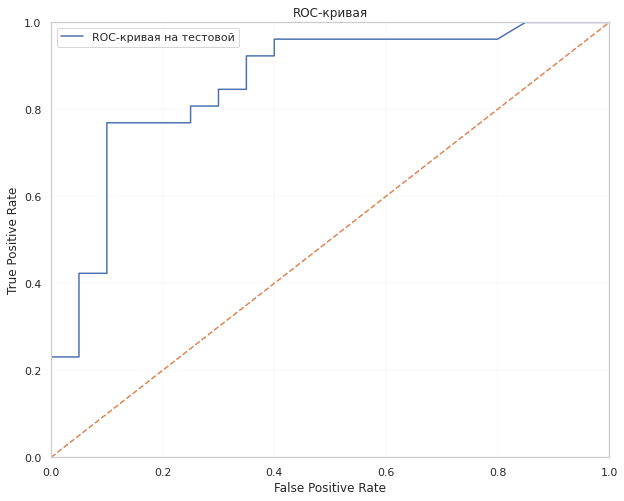

In [286]:
# Исследуем ROC-кривую нашей модели
fpr_test, tpr_test, thresholds = roc_curve(y_test, probabilities_one_valid)
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, label='ROC-кривая на тестовой')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()


В данном проекте мы реализовали модель классификации, вероятность точного предсказания данной модели - почти 78%, что можно считать довольно хорошим показателем.

# Классификация при помощи Нейронной Сети





In [400]:
data = df.drop('TARGET', axis=1)
XX = data.astype(int)
print(XX.shape)

y = np.array(df['TARGET'])
YY = y.reshape(-1, 1).astype(int)
print(YY.shape)

(303, 13)
(303, 1)


In [402]:
#  Разобъем всю выборку на три части: обучающую, валидационную и тестовую.
x_train, x_test, y_train, y_test = train_test_split(XX, YY, test_size=0.2, shuffle=True)    
y_train.reshape(-1, 1)
print(f'X_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {x_test.shape}, y_test: {y_test.shape}')

X_train: (242, 13), y_train: (242, 1)
X_test: (61, 13), y_test: (61, 1)


In [403]:
# Функция пересоздаёт пустую сеть
def createModel():

  # Создаем сеть
  model = Sequential()

  # Добавляем слои
  model.add(Dense(60, input_dim=13, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(30,  activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  # Компилируем сеть
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

  return model # Возвращаем созданную сеть

In [404]:
# Создаём пустую сеть при помощи функции createModel()
model1 = createModel()
model1.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 60)                840       
_________________________________________________________________
dense_145 (Dense)            (None, 30)                1830      
_________________________________________________________________
dense_146 (Dense)            (None, 1)                 31        
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


In [405]:
# Обучаем сеть
history = model1.fit(x_train, 
          y_train,
          batch_size=4, 
          epochs=10,
          validation_split=0.2, # Указываем 20% случайных примеров для проверочной выборки
          verbose=1)

Epoch 1/10
49/49 [==============================] - 1s 5ms/step - loss: 1.5661 - accuracy: 0.5873 - val_loss: 1.4019 - val_accuracy: 0.5714
Epoch 2/10
49/49 [==============================] - 0s 2ms/step - loss: 1.1857 - accuracy: 0.6290 - val_loss: 0.7518 - val_accuracy: 0.6122
Epoch 3/10
49/49 [==============================] - 0s 2ms/step - loss: 0.6127 - accuracy: 0.7159 - val_loss: 1.3268 - val_accuracy: 0.5306
Epoch 4/10
49/49 [==============================] - 0s 2ms/step - loss: 1.3027 - accuracy: 0.4821 - val_loss: 0.7768 - val_accuracy: 0.6531
Epoch 5/10
49/49 [==============================] - 0s 2ms/step - loss: 0.9757 - accuracy: 0.6570 - val_loss: 0.6550 - val_accuracy: 0.5918
Epoch 6/10
49/49 [==============================] - 0s 2ms/step - loss: 0.7490 - accuracy: 0.6089 - val_loss: 0.6012 - val_accuracy: 0.6531
Epoch 7/10
49/49 [==============================] - 0s 2ms/step - loss: 0.6195 - accuracy: 0.7252 - val_loss: 0.6687 - val_accuracy: 0.7143
Epoch 8/10
49/49 [==

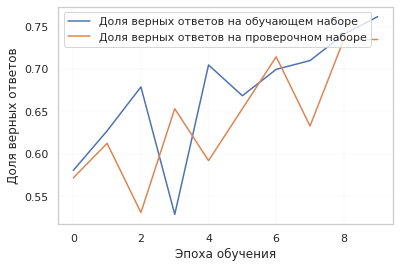

In [407]:
# Выводим график обучения 
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

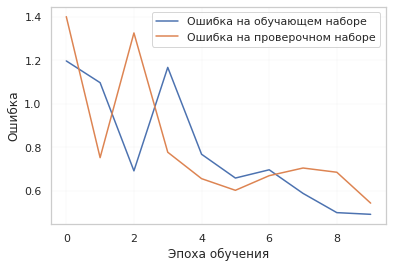

In [408]:
# Выводим графики ошибки
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [410]:
# Вычисляем результаты сети на тестовом наборе
scores = model1.evaluate(x_test, y_test, verbose=True)

# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке
print(scores)
print("Доля верных ответов на тестовых данных, в процентах: ", round(scores[1] * 100, 2), "%", sep="")

2/2 [==============================] - 0s 4ms/step - loss: 0.4033 - accuracy: 0.8525
[0.40330493450164795, 0.8524590134620667]
Доля верных ответов на тестовых данных, в процентах: 85.25%


In [411]:
# Значения точности распознавания на проверочной выборке по эпохам
val_acc = history.history['val_accuracy']
for i in range(len(val_acc)):
  print("Эпоха: ", i, " точность: ", round(100*val_acc[i], 1), "%", sep="")

Эпоха: 0 точность: 57.1%
Эпоха: 1 точность: 61.2%
Эпоха: 2 точность: 53.1%
Эпоха: 3 точность: 65.3%
Эпоха: 4 точность: 59.2%
Эпоха: 5 точность: 65.3%
Эпоха: 6 точность: 71.4%
Эпоха: 7 точность: 63.3%
Эпоха: 8 точность: 73.5%
Эпоха: 9 точность: 73.5%


loss - binary_crossentropy - Вычисляет потерю кросс-энтропии между истинными и предсказанными метками. Используйте эту потерю перекрестной энтропии, когда существует только два класса меток (предполагается, что это 0 и 1).

metrics - accuracy - Измеряет количество верно классифицированных объектов относительно общего количества всех объектов